Цель: определить параметры формулы, используемой в EngineWise для коррекции

In [80]:
import pandas as pd
from sklearn.metrics import mean_absolute_error

data = pd \
  .read_csv('../takeoff-merged-VQ-BDU-30s.csv', parse_dates=['reportts']) 

data.loc[data['oat'].isna(), ['oat']] = data.loc[data['oat'].isna(), :]['tat']

Columns: N1 (unbiased), N1C2 (corrected)

In [83]:
X = data[['n1a', 'n1c2']]

MAE Original:

In [84]:
mean_absolute_error(X['n1a'], X['n1c2'])

1.6565512333965846

#### Theta factor correction

In [85]:
theta = (data['oat'] + 273.15) / 288.15

alpha = 0.5

n1k = X['n1a'] / (theta ** alpha)

mean_absolute_error(n1k, X['n1c2'])

0.27838580217559816

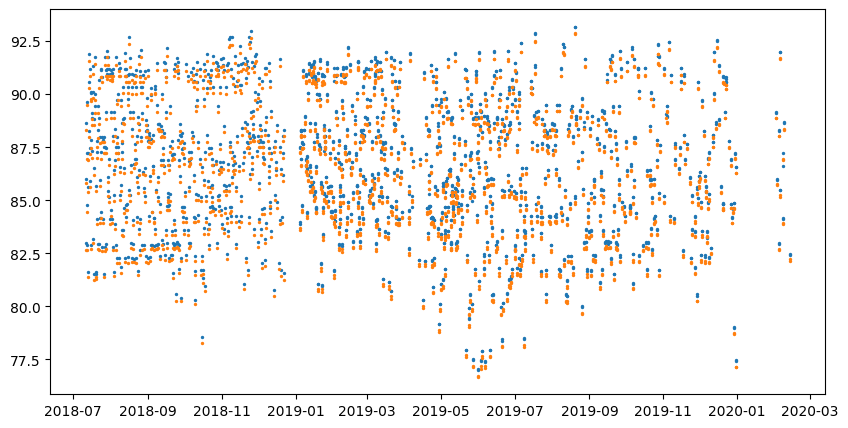

In [86]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 5))
# plt.scatter(data['reportts'], data['n1a'], s=2)
plt.scatter(data['reportts'], n1k, s=2)
plt.scatter(data['reportts'], data['n1c2'], s=2)

In [87]:
(n1k - data['n1c2']).describe()

count    2108.000000
mean        0.275653
std         0.070413
min        -1.001185
25%         0.239826
50%         0.280405
75%         0.315738
max         0.484923
dtype: float64

Now let's try to adjust alpha more closely:

In [ ]:
a = 0.40
min_err = 100
min_a = a
while a <= 0.55:
  n1k = X['n1a'] / (theta ** a)
  err = mean_absolute_error(n1k, X['n1c2'])
  if err < min_err:
    min_a = a
    min_err = err
  a += 0.00001

min_a, min_err

(0.46483000000006486, 0.22588277925626918)

Minimum error a is 0.5255

In [ ]:
a = 0.5255
y_err = X['n1c2'] - (X['n1a'] / (theta ** a))